## Quick Setup
1. Create a new virtualenv and activate
    > virtualenv pyenv3.6 -p python3.6
    > source pyenv3.6/bin/activate
2. Install packages
    > pip install -r requirements.txt
3. Add virtualenv as a new jupyter kernel
    > ipython kernel install --user --name=pyenv3.6
4. In the notebook's menu, select `kernel` > `Change kernel` > `pyenv3.6`
5. Run the code snippet below and scroll down to the 'Batch Processing' section.

In [199]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
from scipy import signal

# num of frames in a window. 50 * 5ms = 250ms
WINDOW_SIZE = 50
FRAME_BEFORE_PEAK = 35

pwd = Path(os.path.dirname(os.path.realpath('__file__')))
raw_data_dir = pwd/'raw_data'
output_dir = pwd/'sliced_data'

raw_data_dir, output_dir

(PosixPath('/Users/senyuuri/workspace/gesture-drumkit/Model/raw_data'),
 PosixPath('/Users/senyuuri/workspace/gesture-drumkit/Model/sliced_data'))

## Proof of Concept

In [144]:
fname = 'gesture-down-bpm60-50samples.csv'
df = pd.read_csv(raw_data_dir/fname)

# normalise timestamp
min_time = df['timestamp_ms'].min()
df['rms'] = df.apply(lambda row: math.sqrt(row['data1']**2 + row['data2']**2 + row['data3']**2), axis=1)
df['time_ms'] = df.apply(lambda row: row['timestamp_ms'] - min_time, axis=1)
df = df.drop(['timestamp_ms'], axis=1)
df[:5]

,sensor_type,data1,data2,data3,rms,time_ms
0,GYROSCOPE,13.93000,1.750000,-3.640000,14.503689,0
1,ACCELEROMETER,-0.07657,0.567099,10.504492,10.520067,3
2,GYROSCOPE,14.91000,2.030000,-4.200000,15.622708,6
3,ACCELEROMETER,-0.07657,0.567099,10.504492,10.520067,8
4,GYROSCOPE,15.75000,2.450000,-4.690000,16.615087,11


In [123]:
# split by sensor type
gyro_df = df.loc[df['sensor_type'] == 'GYROSCOPE'].reset_index(drop=True)
acce_df = df.loc[df['sensor_type'] == 'ACCELEROMETER'].reset_index(drop=True)
# rename colume
gyro_df.columns = ['sensor_type', 'g_x', 'g_y', 'g_z', 'rms', 'time_ms']
acce_df.columns = ['sensor_type', 'a_x', 'a_y', 'a_z', 'rms', 'time_ms']
acce_df[:5]

,sensor_type,a_x,a_y,a_z,rms,time_ms
0,ACCELEROMETER,-0.076570,0.567099,10.504492,10.520067,3
1,ACCELEROMETER,-0.076570,0.567099,10.504492,10.520067,8
2,ACCELEROMETER,-0.074177,0.684347,10.509278,10.531797,13
3,ACCELEROMETER,-0.074177,0.684347,10.509278,10.531797,18
4,ACCELEROMETER,-0.026321,0.734596,10.494920,10.520631,23


In [84]:
acce_df.describe()

,a_x,a_y,a_z,rms,time_ms
count,10050.000000,10050.000000,10050.000000,10050.000000,10050.000000
mean,1.972802,-2.984091,8.569613,10.183886,25141.936915
std,5.019730,2.131539,4.804617,5.945352,14516.375719
min,-5.871986,-15.014962,-3.416951,0.134297,3.000000
25%,-1.686940,-3.907479,6.245865,7.020254,12571.500000
50%,0.236889,-2.723032,7.186843,8.034730,25141.500000
75%,4.764708,-1.823331,9.320044,10.990012,37711.000000
max,29.173294,4.924429,29.881569,39.158088,50281.000000


In [85]:
gyro_df.describe()

,g_x,g_y,g_z,rms,time_ms
count,10050.000000,10050.000000,10050.000000,10050.000000,10050.000000
mean,0.172799,0.565642,-1.981411,114.444879,25139.796816
std,33.538221,138.881774,39.261084,94.126163,14516.375880
min,-148.890000,-589.120000,-181.930010,1.315181,0.000000
25%,-16.170000,-45.902501,-15.312500,43.442288,12569.500000
50%,1.820000,31.990000,7.000000,91.976619,25139.500000
75%,16.992500,100.520000,24.202500,151.986931,37709.000000
max,198.240000,210.910000,78.190000,596.564067,50279.000000


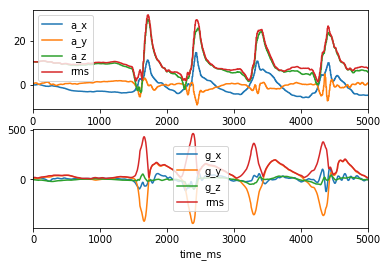

In [124]:
fig, axes = plt.subplots(nrows=2, ncols=1)
acce_df_tmp = acce_df[['a_x', 'a_y', 'a_z', 'rms','time_ms']][:1000]
acce_df_tmp.plot(x='time_ms', ax=axes[0])
gyro_df_tmp = gyro_df[['g_x', 'g_y', 'g_z', 'rms','time_ms']][:1000]
gyro_df_tmp.plot(x='time_ms', ax=axes[1])

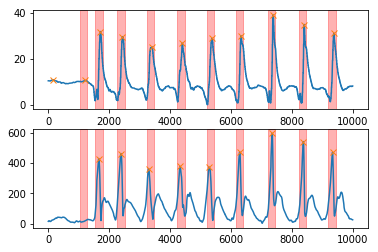

In [176]:
# find peaks
# given sampling rate = 200 Hz and our minimum bpm for data collection is 120 (0.5s)
# peaks must be separate by a minimum of 100 samples
fig, axes = plt.subplots(nrows=2, ncols=1)

# TODO remove [:2000]
acce_mean_peak = acce_df['rms'].mean()
acce_peaks, _ = signal.find_peaks(acce_df['rms'][:2000], distance=100, height=acce_mean_peak)
axes[0].plot(acce_df['time_ms'][:2000], acce_df['rms'][:2000])
axes[0].plot(acce_df['time_ms'][acce_peaks], acce_df['rms'][acce_peaks], 'x')

gyro_mean_peak = gyro_df['rms'].mean()
gyro_peaks, _ = signal.find_peaks(gyro_df['rms'][:2000], distance=100, height=gyro_mean_peak)
axes[1].plot(gyro_df['time_ms'][:2000], gyro_df['rms'][:2000])
axes[1].plot(gyro_df['time_ms'][gyro_peaks], gyro_df['rms'][gyro_peaks], 'x')

# slice by accelerator's peaks
# notice acce_peak here is the index, need to convert to time_ms before slicing
# because the same index is mapped to different time in acce_df and gyro_df 
for p in acce_peaks:
    # ignore imcomplete window
    start = p - FRAME_BEFORE_PEAK
    end = start + WINDOW_SIZE
    if start > 0 and end < len(acce_df):
        start_time = acce_df['time_ms'][start]
        end_time = acce_df['time_ms'][end]
        
        # draw selected slices
        axes[0].axvspan(start_time, end_time, alpha=0.3, color='red')
        axes[1].axvspan(start_time, end_time, alpha=0.3, color='red')
        

In [180]:
cat_dir = output_dir/'gesture_down'
if not os.path.exists(cat_dir):
    os.mkdir(cat_dir)

# save each slice in a new file
f_count = 0
for p in acce_peaks:
    # ignore imcomplete window
    start = p - FRAME_BEFORE_PEAK
    end = start + WINDOW_SIZE
    if start > 0 and end < len(acce_df):
        start_time = acce_df['time_ms'][start]
        end_time = acce_df['time_ms'][end]
        #print(acce_df.truncate(before=start, after=end))
        gyro_range = gyro_df['time_ms'].searchsorted([start_time, end_time])
        #print(gyro_df.truncate(before=gyro_range[0], after=gyro_range[1]))
        
        fout_name = '%d_%d_%d.csv' % (f_count, start_time, end_time)
        with open(cat_dir/fout_name, 'a') as f:
            acce_df.truncate(before=start, after=end).to_csv(f, header=False)
            gyro_df.truncate(before=gyro_range[0], after=gyro_range[1]).to_csv(f, header=False)
        f_count += 1

## Batch Processing

In [235]:
plt.figure(figsize=(12, 12))

def draw(acce_df, gyro_df, acce_peaks, gyro_peaks):
    '''visualise overall peaks + slices and zoom in to show the first 2000 samples'''
    SIZE = 2000
    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.suptitle(raw_file)
    
    # draw rms + peaks
    axes[0, 0].set_title('acce_df')
    axes[0, 0].plot(acce_df['time_ms'], acce_df['rms'])
    axes[0, 0].plot(acce_df['time_ms'][acce_peaks], acce_df['rms'][acce_peaks], 'x')
    axes[1, 0].set_title('gyro_df')
    axes[1, 0].plot(gyro_df['time_ms'], gyro_df['rms'])
    axes[1, 0].plot(gyro_df['time_ms'][gyro_peaks], gyro_df['rms'][gyro_peaks], 'x')
    
    # draw first 2000 samples
    acce_df_tmp = acce_df[['a_x', 'a_y', 'a_z', 'rms','time_ms']][:1000]
    acce_df_tmp.plot(x='time_ms', ax=axes[0, 1])
    gyro_df_tmp = gyro_df[['g_x', 'g_y', 'g_z', 'rms','time_ms']][:1000]
    gyro_df_tmp.plot(x='time_ms', ax=axes[1, 1])
    acce_mean_peak = acce_df['rms'].mean()
    acce_peaks_begin, _ = signal.find_peaks(acce_df['rms'][:SIZE], distance=100, height=acce_mean_peak)
    axes[0, 1].plot(acce_df['time_ms'][acce_peaks_begin], acce_df['rms'][acce_peaks_begin], 'x')

    gyro_mean_peak = gyro_df['rms'].mean()
    gyro_peaks_begin, _ = signal.find_peaks(gyro_df['rms'][:SIZE], distance=100, height=gyro_mean_peak)
    axes[1, 1].plot(gyro_df['time_ms'][gyro_peaks_begin], gyro_df['rms'][gyro_peaks_begin], 'x')
    
    for p in acce_peaks_begin:
        # ignore imcomplete window
        start = p - FRAME_BEFORE_PEAK
        end = start + WINDOW_SIZE
        if start > 0 and end < len(acce_df):
            start_time = acce_df['time_ms'][start]
            end_time = acce_df['time_ms'][end]

            # draw selected slices
            axes[0, 1].axvspan(start_time, end_time, alpha=0.1, color='red')
            axes[1, 1].axvspan(start_time, end_time, alpha=0.1, color='red')

<Figure size 864x864 with 0 Axes>

(1/2) gesture-down-bpm60-50samples.csv, 51 slice(s) created.
(2/2) gesture-up-bpm60-50samples.csv, 53 slice(s) created.


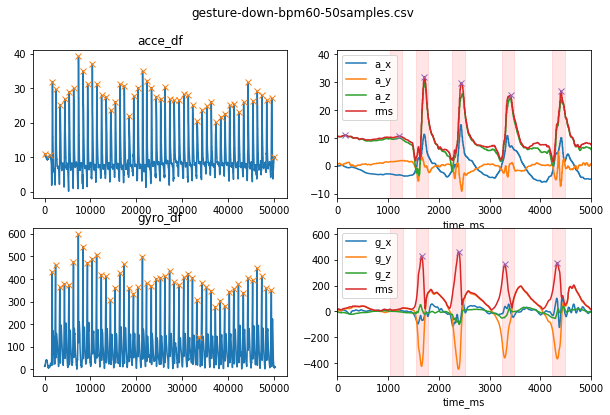

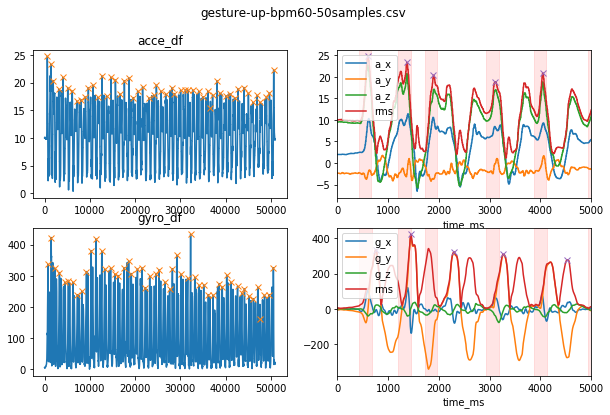

In [239]:
for idx, raw_file in enumerate(os.listdir(raw_data_dir)):
    df = pd.read_csv(raw_data_dir/raw_file)

    # create the output folder if not exists
    cat_dir = output_dir/('-'.join(raw_file.split('-')[:2]))
    bpm_tag = raw_file.split('-')[2]
    if not os.path.exists(cat_dir):
        os.mkdir(cat_dir)
    
    # calculate rms
    df['rms'] = df.apply(lambda row: math.sqrt(row['data1']**2 + row['data2']**2 + row['data3']**2), axis=1)
    
    # normalise timestamp
    min_time = df['timestamp_ms'].min()
    df['time_ms'] = df.apply(lambda row: row['timestamp_ms'] - min_time, axis=1)
    df = df.drop(['timestamp_ms'], axis=1)
    
    # split by sensor type
    gyro_df = df.loc[df['sensor_type'] == 'GYROSCOPE'].reset_index(drop=True)
    acce_df = df.loc[df['sensor_type'] == 'ACCELEROMETER'].reset_index(drop=True)
    
    # rename colume
    gyro_df.columns = ['sensor_type', 'g_x', 'g_y', 'g_z', 'rms', 'time_ms']
    acce_df.columns = ['sensor_type', 'a_x', 'a_y', 'a_z', 'rms', 'time_ms']
    
    # find peaks
    acce_mean_peak = acce_df['rms'].mean()
    acce_peaks, _ = signal.find_peaks(acce_df['rms'], distance=100, height=acce_mean_peak)
    gyro_mean_peak = gyro_df['rms'].mean()
    gyro_peaks, _ = signal.find_peaks(gyro_df['rms'], distance=100, height=gyro_mean_peak)
    
    # DEBUG: visualise peaks
    draw(acce_df, gyro_df, acce_peaks, gyro_peaks)

    # slice around the peak and save to new files
    f_count = 0
    for p in acce_peaks:
        # ignore imcomplete window
        start = p - FRAME_BEFORE_PEAK
        end = start + WINDOW_SIZE
        if start > 0 and end < len(acce_df):
            start_time = acce_df['time_ms'][start]
            end_time = acce_df['time_ms'][end]
            gyro_range = gyro_df['time_ms'].searchsorted([start_time, end_time])

            fout_name = '%s_%d_%d_%d.csv' % (bpm_tag, f_count, start_time, end_time)
            with open(cat_dir/fout_name, 'a') as f:
                acce_df.truncate(before=start, after=end).to_csv(f, header=False)
                gyro_df.truncate(before=gyro_range[0], after=gyro_range[1]).to_csv(f, header=False)
            f_count += 1

    print('(%d/%d) %s, %d slice(s) created.' % (idx+1, len(os.listdir(raw_data_dir)), raw_file, f_count))
